In [ ]:
import joblib
import numpy as np

import mujoco
from mujoco import mjx

from pathlib import Path
from hydrax.algs import CEM, MPPI, PredictiveSampling, Evosax
from hydrax.tasks.cart_pole import CartPole
from tasks.cart_pole_unconstrained import CartPoleUnconstrained
from tasks.pusht_unconstrained import PushTUnconstrained
from tasks.pendulum_unconstrained import PendulumUnconstrained
from tasks.double_cart_pole_unconstrained import DoubleCartPoleUnconstrained

from hydrax.tasks.cube import CubeRotation
from hydrax.tasks.pusht import PushT
from hydrax.tasks.humanoid_standup import HumanoidStandup
from hydrax.tasks.humanoid_mocap import HumanoidMocap
from hydrax.tasks.walker import Walker
from traj_opt_helper import traj_opt_helper
from traj_opt.algorithms import create_algorithm
import os

# Prevent JAX from pre-allocating all GPU memory
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

# Limit JAX to use only 50% of GPU memory (adjust as needed)
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'

/home/rooh/miniconda3/envs/hydrax/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Trajectory Optimization Benchmarks

This notebook helps you run trajectory-optimization benchmarks on a robotics problem and visualize the solution.


**Supported sampling-based algorithms:**
- MPPI  
- MPPI-CMA  
- Predictive Sampling  
- CMA-ES  
- Randomized Smoothing  

**Supported tasks:**

*Easy tasks*:
- Cartpole  
- Inverted Pendulum  
- Double Cartpole

*Hard tasks (contact-rich)*:
- PushT  
- Humanoid  
- Cube Rotation  


# Define you algorithm, task, and parameters

In [2]:

algorithms = ["MPPI-CMA", "PredictiveSampling", "MPPI"]# , "CMA-ES", "RandomizedSmoothing"] # MPPI, MPPI-CMA, RandomizedSmoothing, PredictiveSampling, CMA-ES
task_name = "Humanoid" # "CartPole", "InvertedPendulum", "DoubleCartPole", "PushT", "CubeRotation", "Humanoid"
# Parameters
num_trails = 6
max_iterations = 200
num_samples = 2048
sigma_init = 0.3
temperature = 0.1
spline = "zero"
horizon = 1.0
num_knots = 10 # set this to (horizon/mj_model.opt.timestep) equals to no spline interpolation

# Load task (add your task here)

In [3]:
# Easy tasks
if task_name == "CartPole":
    # CartPole
    task = CartPoleUnconstrained()
    task.dt = 0.01
    task.mj_model.opt.timestep = 0.01
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer

elif task_name == "InvertedPendulum":
    task = PendulumUnconstrained()
    task.dt = 0.01
    task.mj_model.opt.timestep = 0.01
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer
    mj_data.qpos[:] = np.array([0.0])
    mj_data.qvel[:] = np.array([0.0])

elif task_name == "DoubleCartPole":
    task = DoubleCartPoleUnconstrained()
    task.dt = 0.01
    task.mj_model.opt.timestep = 0.01
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer

# Hard tasks (contact rich)
elif task_name == "PushT":
    # PushT
    task = PushTUnconstrained()
    task.dt = 0.02
    task.mj_model.opt.timestep = 0.02
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5
    task.mj_model.opt.o_solimp = [0.9, 0.95, 0.001, 0.5, 2]

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer
    mj_data.qpos = [0.1, 0.1, 1.3, 0.0, 0.0]

elif task_name == "CubeRotation":
    # CubeRotation
    task = CubeRotation()
    task.dt = 0.02
    task.dt = 0.02
    task.mj_model.opt.timestep = 0.02
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5
    task.mj_model.opt.o_solimp = [0.9, 0.95, 0.001, 0.5, 2]

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer

elif task_name == "Humanoid":
    #HumanoidMocap
    task = HumanoidMocap(reference_filename="Lafan1/mocap/UnitreeG1/walk1_subject2.npz") # Humanoid balancing!
    task.dt = 0.02
    task.mj_model.opt.timestep = 0.02
    task.mj_model.opt.iterations = 1
    task.mj_model.opt.ls_iterations = 5
    task.mj_model.opt.o_solimp = [0.9, 0.95, 0.001, 0.5, 2]

    task.model = mjx.put_model(task.mj_model) # Model used by the sampling-based optimizer
    mj_model = task.mj_model # Model used by the simulator when visualizing results

    mj_data = mujoco.MjData(mj_model) # Data for both simulator and optimizer
    mj_data.qpos[:] = task.reference[0]
    initial_knots = task.reference[: num_knots, 7:]

else:
    print(f"{task_name} is not implemented")

# Run benchmarks
* The control trajectory of the best solution will be plotted

Trajectory Optimization with 10 steps over a 1.0 second horizon.
Controller dt: 0.02
Simulator dt: 0.02
Jitting the controller...
Time to jit: 14.318 seconds
path created: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap


100%|██████████| 200/200 [00:15<00:00, 13.06it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.09it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.18it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Optimization done.


100%|██████████| 200/200 [00:14<00:00, 13.42it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.05it/s]


Optimization done.


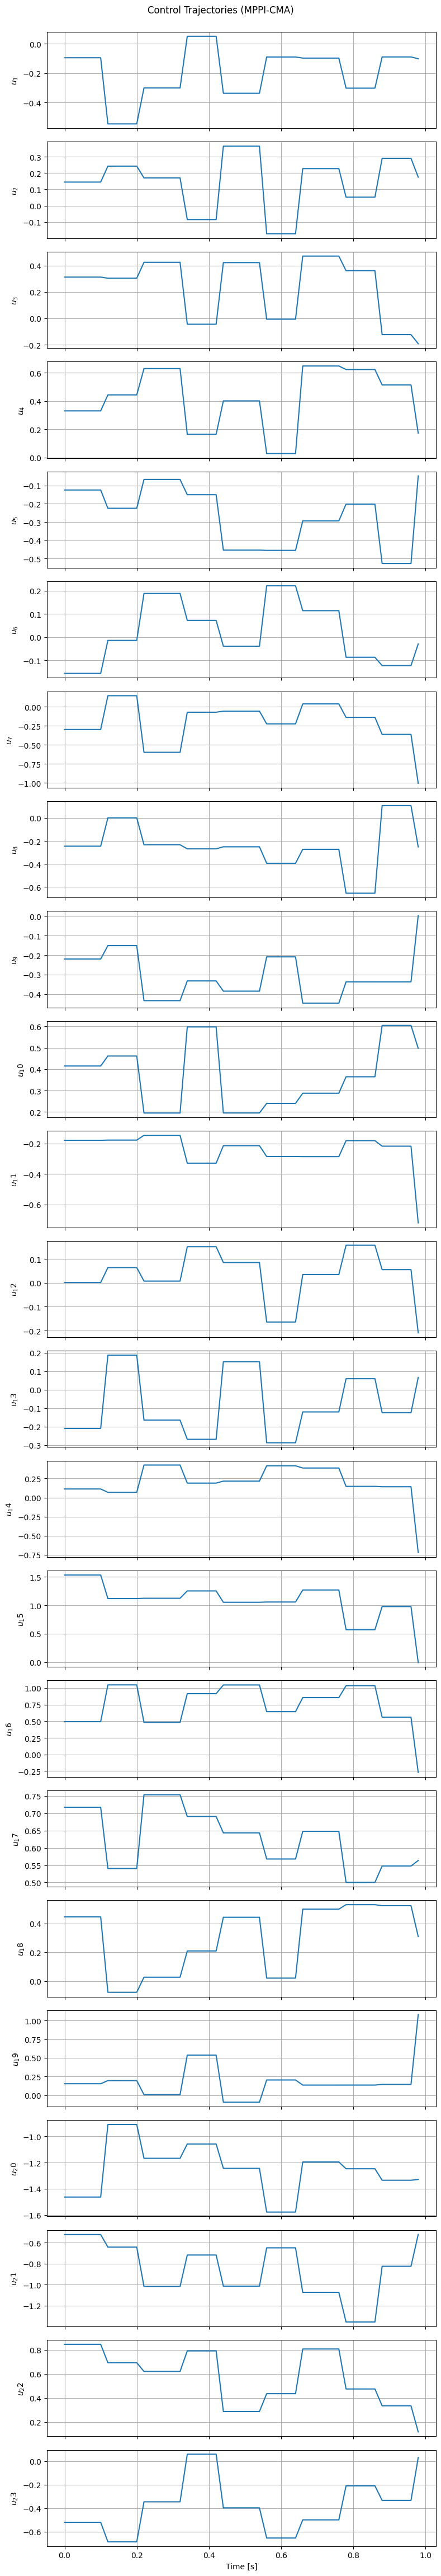

Results saved
Trajectory Optimization with 10 steps over a 1.0 second horizon.
Controller dt: 0.02
Simulator dt: 0.02
Jitting the controller...
Time to jit: 5.203 seconds
path created: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap


100%|██████████| 200/200 [00:15<00:00, 13.21it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.27it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.30it/s]


Optimization done.


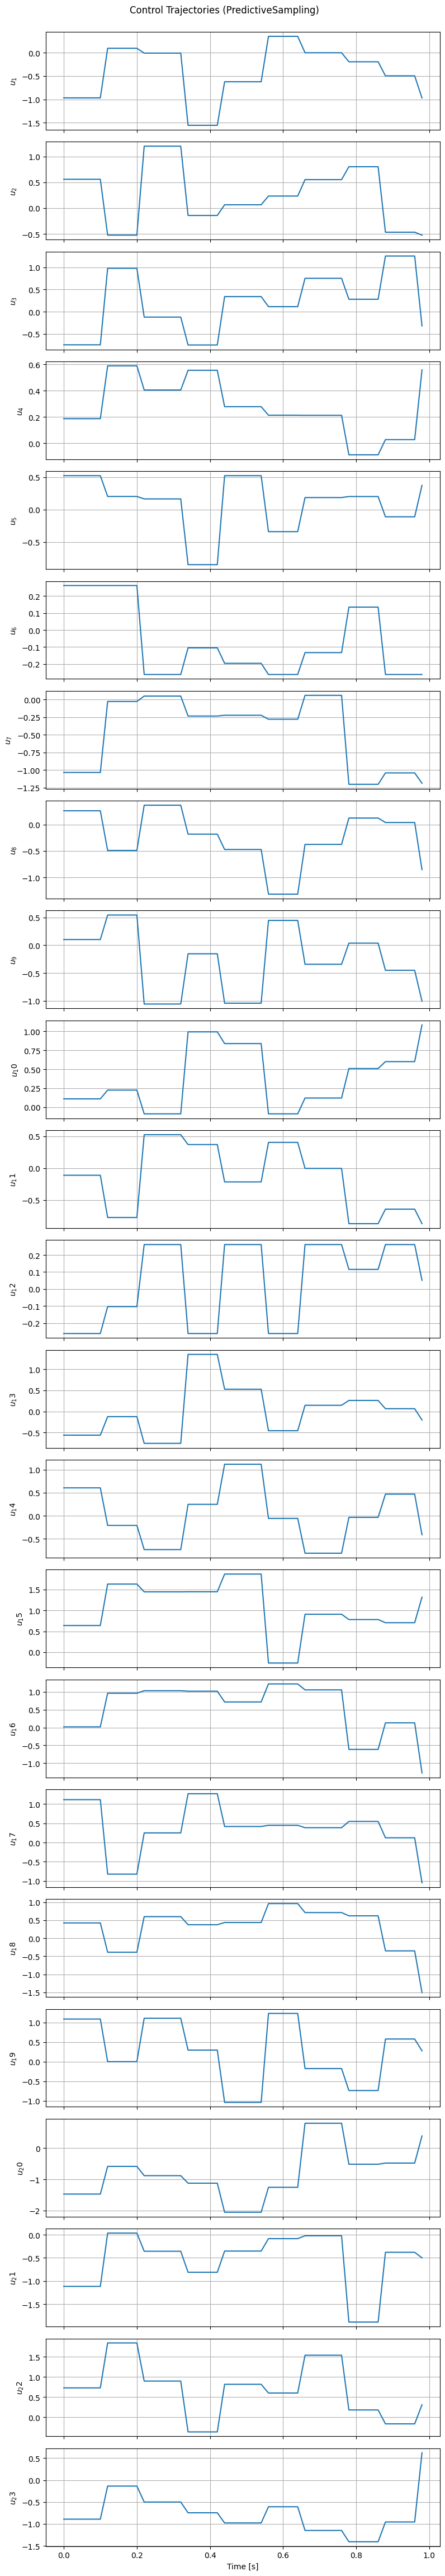

Results saved
Trajectory Optimization with 10 steps over a 1.0 second horizon.
Controller dt: 0.02
Simulator dt: 0.02
Jitting the controller...
Time to jit: 5.119 seconds
path created: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap


100%|██████████| 200/200 [00:15<00:00, 13.32it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.29it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.28it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.25it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.26it/s]


Optimization done.


100%|██████████| 200/200 [00:15<00:00, 13.24it/s]


Optimization done.


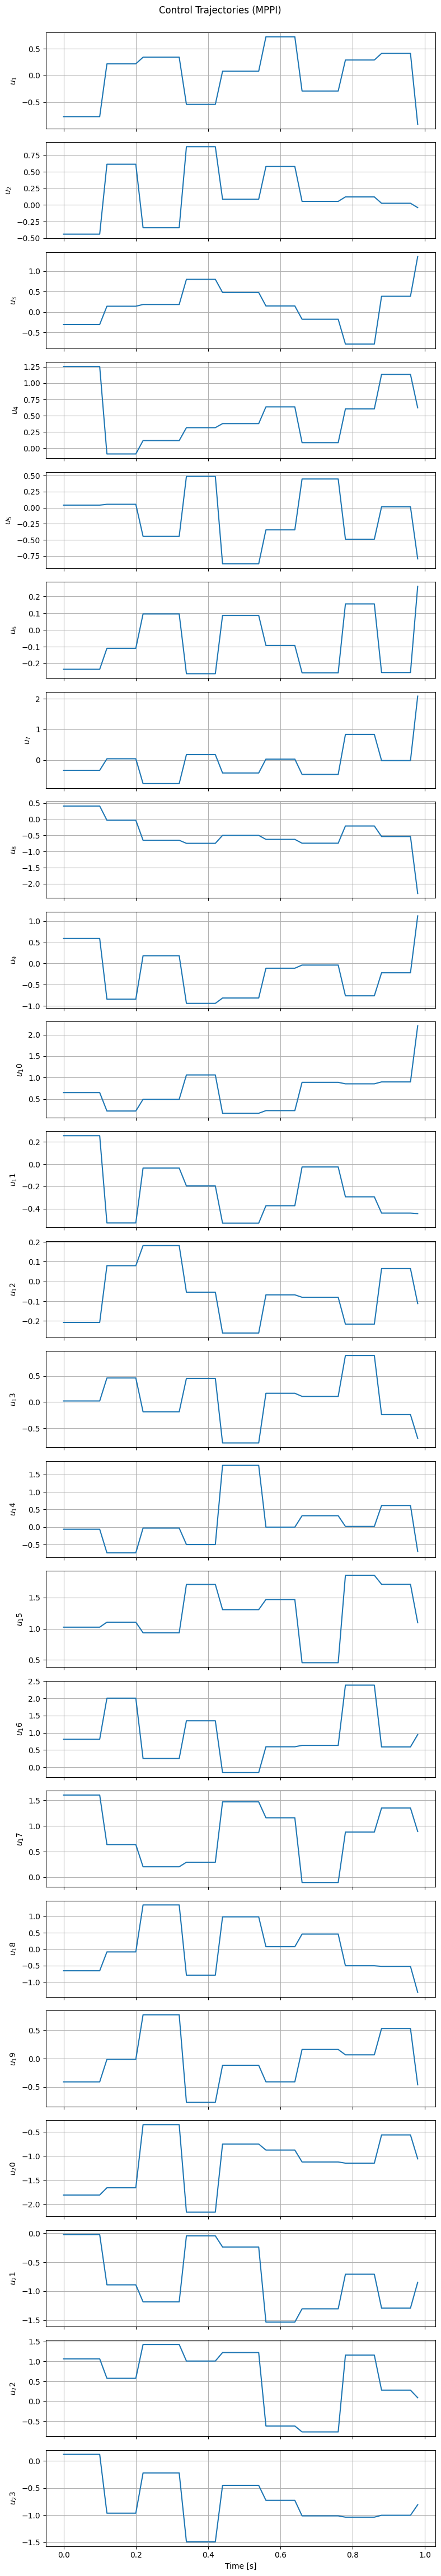

Results saved


In [4]:
for algorithm in algorithms:

    ctrl = create_algorithm(name = algorithm, 
                        task = task,
                        num_samples = num_samples,
                        horizon = horizon,
                        num_knots = num_knots,
                        spline = spline,
                        temperature = temperature,
                        noise = sigma_init)

    to = traj_opt_helper(algorithm, ctrl, mj_model, mj_data)
    to.trails(max_iteration=max_iterations, num_trails = num_trails)

# Generate convergence plot

┌──────────────────────────────────────────────┐
│        Visualising results…                  │
└──────────────────────────────────────────────┘
Results directory: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap


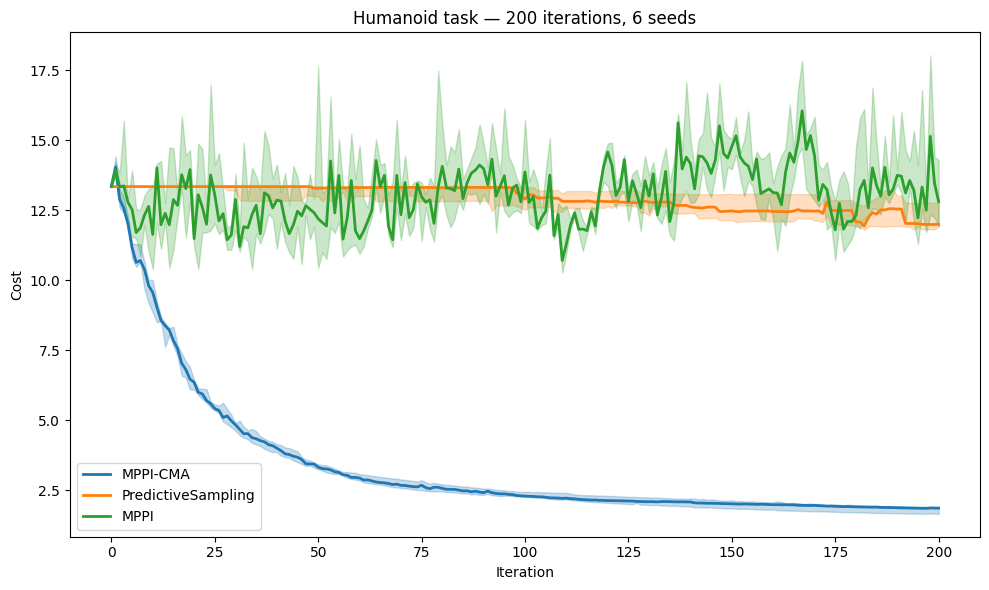

In [8]:
import matplotlib.pyplot as plt

print("┌──────────────────────────────────────────────┐")
print("│        Visualising results…                  │")
print("└──────────────────────────────────────────────┘")

results_dir = Path(traj_opt_helper.get_path(task))
print(f"Results directory: {results_dir}")

methods = {}                                   # keep raw algorithm names

for alg in algorithms:
    f = results_dir / f"{alg}_costs_trails_average.pkl"
    try:
        arr = joblib.load(f)                   # shape (n_trials, n_iters)
        methods[alg] = np.asarray(arr)
    except FileNotFoundError:
        print(f"[warn] {f.name} not found; skipping.")

if not methods:
    raise RuntimeError("No cost files loaded — nothing to plot.")

iters  = np.arange(next(iter(methods.values())).shape[1])
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(10, 6))
for (name, costs), color in zip(methods.items(), colors):
    q25, med, q75 = np.quantile(costs, [0.25, 0.5, 0.75], axis=0)
    plt.plot(iters, med, lw=2, label=name, color=color)
    plt.fill_between(iters, q25, q75, color=color, alpha=0.25)

plt.title(f"{task_name.capitalize()} task — {costs.shape[1]-1} iterations, {num_trails} seeds")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.tight_layout()
plt.show()

# Visualize solution
-In simulator or as a gif

In [6]:
# try:
#     to.visualize_rollout(task, controller_name="MPPI-CMA")
# except NameError:
#     pass


GIF saved to: /home/rooh/workspace/rs-rl/traj_opt/data/HumanoidMocap/MPPI.gif


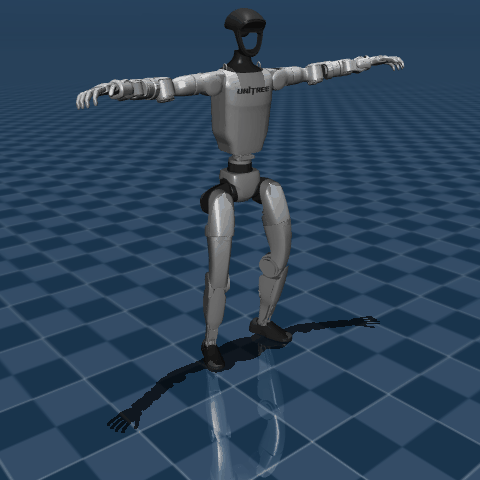

In [9]:
to.visualize_rollout_gif(task, "MPPI", fps=30)
